<a href="https://colab.research.google.com/github/aryanVanaik/ImageClassification/blob/main/Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###The Imports

In [2]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import tqdm.auto as tqdm
## Importing non standard libries
try:
  import torchmetrics

except:
  !pip install torchmetrics
  import torchmetrics

from torchmetrics.classification import Accuracy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.2/517.2 KB 21.8 MB/s eta 0:00:00


In [3]:
# Device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cuda'

## Obtaining Data provided by courtrsy of mkdbourke github link: https://github.com/mrdbourke/pytorch-deep-learning

In [4]:
import requests
import zipfile
from pathlib import Path

# path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesnt exist, download it and prepare it...
if image_path.is_dir():
  print(f"{image_path} directory exists skipping download")

else:
  print(f"{image_path} does not exist, creating one...")
  image_path.mkdir(parents=True,exist_ok=True)

with open(data_path/"pizza_steak_sushi.zip","wb") as f:
 
  request = requests.get(" https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downloading pizza steak, sushi data")
  f.write(request.content)

with zipfile.ZipFile(data_path/"pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unzipping data")
  zip_ref.extractall(image_path)

data/pizza_steak_sushi does not exist, creating one...
Unzipping data


In [5]:
# Setup train and testing paths
train_dir = image_path/ "train"
test_dir = image_path/ "test"

### Creating the datasets

In [6]:
from torchvision import transforms,datasets
train_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor() 
])
train_transform_aug = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor() 
])

test_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor() 
])

In [7]:


train_data = datasets.ImageFolder(root=train_dir,
                                  transform=train_transform, # a tranform for the data
                                  target_transform=None) # a transfrom for the label/target 

train_data_aug = datasets.ImageFolder(root=train_dir,
                                  transform=train_transform_aug, # a tranform for the data
                                  target_transform=None) # a transfrom for the label/target 

test_data = datasets.ImageFolder(root=test_dir,
                                  transform=test_transform, # a tranform for the data
                                  target_transform=None)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
                ToTensor()
            ), Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
                ToTensor()
            ))

In [8]:
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [9]:
# Batchifying the data 
from torch.utils.data import DataLoader
BATCH_SIZE=32
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=1,
                              shuffle=True)
train_dataloader_aug = DataLoader(dataset=train_data_aug,
                              batch_size=BATCH_SIZE,
                              num_workers=1,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=1,
                             shuffle=False)

### The Model will be a smaller representation of the VGG16 network called TinyVGG Implemeted here: https://poloclub.github.io/cnn-explainer/


In [10]:
class TinyVGG(nn.Module):
  def __init__(self,input_shape:int, hidden_units:int, output_shape:int) -> None:
    super().__init__()
    self.conv_layer1 = nn.Sequential(
        nn.Conv2d(in_channels= input_shape,
                  out_channels = hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels =hidden_units,
                  kernel_size=3,
                  stride=1,padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.conv_layer2 = nn.Sequential(
        nn.Conv2d(in_channels= hidden_units,
                  out_channels= hidden_units,
                  kernel_size=3,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(hidden_units,hidden_units, kernel_size=3, padding=0),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = hidden_units *13*13,
                  out_features = output_shape,
                )
    )

  def forward(self,x):
      # x = self.conv_layer1(x)
      # print(x.shape)
      # x = self.conv_layer2(x)
      # print(x.shape)
      # x = self.classifier(x)
      # print(x.shape)
      # return x

    return self.classifier(self.conv_layer2(self.conv_layer1(x)))

In [11]:
# The Model
model_0 = TinyVGG(3,20,len(train_data.classes)).to(device)
model_0

TinyVGG(
  (conv_layer1): Sequential(
    (0): Conv2d(3, 20, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer2): Sequential(
    (0): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3380, out_features=3, bias=True)
  )
)

## Functions for training and testing loop


In [12]:
def train_batch(model:torch.nn.Module,
                dataloader: torch.utils.data.DataLoader,
                loss_fn: torch.nn.Module,
                optimizer:torch.optim.Optimizer,
                device =device):
  model.train()

  train_loss,train_acc=0,0


  for batch, (X,y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)
    y_pred = model(X)

    loss=loss_fn(y_pred,y)
    train_loss+=loss.item()

    optimizer.zero_grad()
    loss.backward()

    optimizer.step()

    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class == y).sum().item()/len(y_pred)


  train_loss = train_loss/len(dataloader)
  train_acc = train_acc/len(dataloader)

  return train_loss,train_acc


  

In [13]:
def test_batch(model:torch.nn.Module,
               dataloader:torch.utils.data.DataLoader,
               loss_fn=torch.nn.Module,
               device=device):
  model.eval()
  test_loss,test_acc =0,0
  
  with torch.inference_mode():
    for batch,(X,y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)
      test_logits = model(X)

      loss = loss_fn(test_logits,y)
      test_loss += loss.item()

      test_pred_label = torch.argmax(torch.softmax(test_logits,dim=1),dim=1)
      test_acc += ((test_pred_label==y).sum().item()/len(test_pred_label))
  test_loss = test_loss/len(dataloader)
  test_acc = test_acc/len(dataloader)
  return test_loss,test_acc



In [14]:
def full_train(model:torch.nn.Module,
               train_dataloader: torch.utils.data.DataLoader,
               test_dataloader:torch.utils.data.DataLoader,
               optimizer:torch.optim.Optimizer,
               loss_fn:torch.nn.Module,
               epochs:int,
               device = device):
  results = {
      "train_loss":[],
      "train_acc":[],
      "test_loss":[],
      "test_acc":[]
  }
  for epoch in range(epochs):
    train_loss,train_acc = train_batch(model,train_dataloader,loss_fn,optimizer,device)
    test_loss,test_acc = test_batch(model,train_dataloader,loss_fn,device)

    if epoch %10 ==0:
      print(f"Epoch: {epoch} | Train_loss: {train_loss:.4f} | Train_acc: {train_acc:.4f} | Test_loss: {test_loss:.4f} | Test_acc {test_acc:.4f}")

      results["train_loss"].append(train_loss)
      results["train_acc"].append(train_acc)
      results["test_loss"].append(test_loss)
      results["test_acc"].append(test_acc)

  return results
  

In [15]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params =model_0.parameters(), lr=0.0001)

In [16]:
model_0_results = full_train(model = model_0,
                             train_dataloader=train_dataloader,
                             test_dataloader =test_dataloader,
                             loss_fn=loss_fn,
                             optimizer =optimizer,
                             epochs=100)

Epoch: 0 | Train_loss: 1.1016 | Train_acc: 0.2852 | Test_loss: 1.0981 | Test_acc 0.3164
Epoch: 10 | Train_loss: 1.0709 | Train_acc: 0.3359 | Test_loss: 1.0595 | Test_acc 0.4453
Epoch: 20 | Train_loss: 0.9154 | Train_acc: 0.6133 | Test_loss: 0.8861 | Test_acc 0.6133
Epoch: 30 | Train_loss: 0.8120 | Train_acc: 0.6484 | Test_loss: 0.8456 | Test_acc 0.5391
Epoch: 40 | Train_loss: 0.8817 | Train_acc: 0.5781 | Test_loss: 0.6946 | Test_acc 0.7227
Epoch: 50 | Train_loss: 0.7201 | Train_acc: 0.7031 | Test_loss: 0.8999 | Test_acc 0.5898
Epoch: 60 | Train_loss: 0.7229 | Train_acc: 0.7383 | Test_loss: 0.8218 | Test_acc 0.6250
Epoch: 70 | Train_loss: 0.8375 | Train_acc: 0.5938 | Test_loss: 0.5917 | Test_acc 0.7617
Epoch: 80 | Train_loss: 0.7566 | Train_acc: 0.6562 | Test_loss: 0.6466 | Test_acc 0.7695
Epoch: 90 | Train_loss: 0.6537 | Train_acc: 0.7734 | Test_loss: 0.6285 | Test_acc 0.7852


In [17]:
model_0_results.keys()
def plot_loss_curves(results):
  """PLots training curves of results dictionary"""

  loss = results["train_loss"]
  test_loss = results["test_loss"]

  accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]
  
  epochs = range(len(results["train_loss"]))

  plt.figure(figsize=(15,7))
  
  plt.subplot(1,2,1)
  plt.plot(epochs,loss,label="train_loss")
  plt.plot(epochs,test_loss,label="test_loss")
  plt.title("loss")
  plt.xlabel("Epochs")
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(epochs,accuracy, label="train_accuracy")
  plt.plot(epochs,test_accuracy, label="test_accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend()

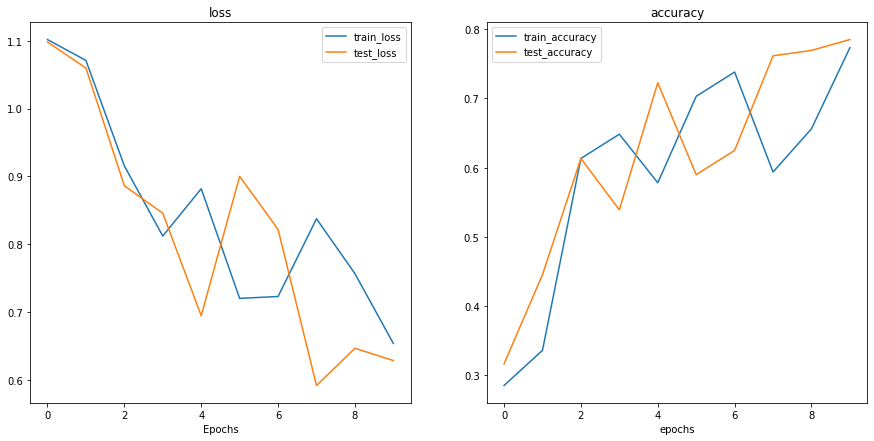

In [18]:
plot_loss_curves(model_0_results)

In [19]:
model_1 = TinyVGG(3,20,len(train_data.classes)).to(device)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params =model_1.parameters(), lr=0.0001)

In [20]:
model_1_results = full_train(model = model_1,
                             train_dataloader=train_dataloader,
                             test_dataloader =test_dataloader,
                             loss_fn=loss_fn,
                             optimizer =optimizer,
                             epochs=100)

Epoch: 0 | Train_loss: 1.1017 | Train_acc: 0.2812 | Test_loss: 1.1013 | Test_acc 0.2812
Epoch: 10 | Train_loss: 1.0964 | Train_acc: 0.4023 | Test_loss: 1.1011 | Test_acc 0.2812
Epoch: 20 | Train_loss: 1.1004 | Train_acc: 0.2812 | Test_loss: 1.1007 | Test_acc 0.2812
Epoch: 30 | Train_loss: 1.0975 | Train_acc: 0.4023 | Test_loss: 1.0972 | Test_acc 0.4023
Epoch: 40 | Train_loss: 1.1003 | Train_acc: 0.2812 | Test_loss: 1.1012 | Test_acc 0.2812
Epoch: 50 | Train_loss: 1.0997 | Train_acc: 0.2812 | Test_loss: 1.1005 | Test_acc 0.2812
Epoch: 60 | Train_loss: 1.0973 | Train_acc: 0.4023 | Test_loss: 1.1012 | Test_acc 0.2812
Epoch: 70 | Train_loss: 1.0967 | Train_acc: 0.4023 | Test_loss: 1.1014 | Test_acc 0.2812
Epoch: 80 | Train_loss: 1.0998 | Train_acc: 0.2812 | Test_loss: 1.0967 | Test_acc 0.4023
Epoch: 90 | Train_loss: 1.1013 | Train_acc: 0.2812 | Test_loss: 1.0997 | Test_acc 0.2812


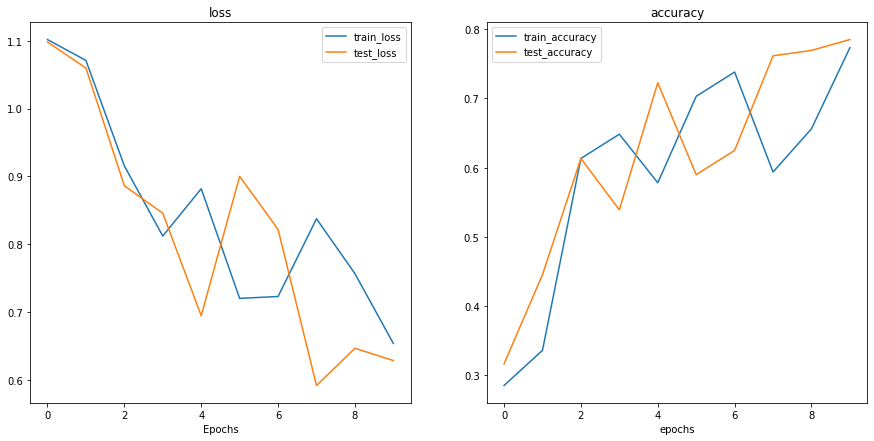

In [21]:
plot_loss_curves(model_0_results)

In [22]:
model_2 = TinyVGG(3,20,len(train_data.classes)).to(device)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params =model_2.parameters(), lr=0.001)

In [23]:
model_2_results = full_train(model = model_2,
                             train_dataloader=train_dataloader_aug,
                             test_dataloader =test_dataloader,
                             loss_fn=loss_fn,
                             optimizer =optimizer,
                             epochs=300)

Epoch: 0 | Train_loss: 1.1050 | Train_acc: 0.2812 | Test_loss: 1.0937 | Test_acc 0.5195
Epoch: 10 | Train_loss: 1.0314 | Train_acc: 0.4023 | Test_loss: 0.9420 | Test_acc 0.6250
Epoch: 20 | Train_loss: 0.8595 | Train_acc: 0.6367 | Test_loss: 0.8327 | Test_acc 0.5781
Epoch: 30 | Train_loss: 0.8723 | Train_acc: 0.5781 | Test_loss: 0.8650 | Test_acc 0.5742
Epoch: 40 | Train_loss: 1.0454 | Train_acc: 0.5195 | Test_loss: 0.8235 | Test_acc 0.6445
Epoch: 50 | Train_loss: 0.7564 | Train_acc: 0.6719 | Test_loss: 0.8265 | Test_acc 0.5742
Epoch: 60 | Train_loss: 0.7738 | Train_acc: 0.6094 | Test_loss: 0.7552 | Test_acc 0.6992
Epoch: 70 | Train_loss: 0.7788 | Train_acc: 0.7305 | Test_loss: 0.5267 | Test_acc 0.8164
Epoch: 80 | Train_loss: 0.8892 | Train_acc: 0.6758 | Test_loss: 0.7459 | Test_acc 0.7695
Epoch: 90 | Train_loss: 0.5473 | Train_acc: 0.7969 | Test_loss: 0.6832 | Test_acc 0.6641
Epoch: 100 | Train_loss: 0.7530 | Train_acc: 0.6289 | Test_loss: 0.6444 | Test_acc 0.7773


KeyboardInterrupt: ignored

In [ ]:
plot_loss_curves(model_2_results)

The reason why the model is not able to learn all the patterns very well is potentially due to the lack of training data. Hence to solve this issue the use of transfer learning will be applied to this problem.

In [1]:
# Downloading helper functions to help with training and testing
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 3426, done.
remote: Counting objects: 100% (124/124), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 3426 (delta 52), reused 100 (delta 44), pack-reused 3302
Receiving objects: 100% (3426/3426), 643.48 MiB | 31.76 MiB/s, done.
Resolving deltas: 100% (1959/1959), done.
Updating files: 100% (222/222), done.


In [24]:
#DOwnloading the efficientNet model from Pytorchs model library
from torchvision.models import efficientnet
import torchvision
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT 
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT 
efficientnet_model =torchvision.models.efficientnet_b0(weights=weights)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth


  0%|          | 0.00/20.5M [00:00<?, ?B/s]

In [25]:
## Changing all the feature layers to nontrainable so that during training our training images do not affect the pre determined weigths of the feature layers
for params in efficientnet_model.features.parameters():
  params.requires_grad=False


In [27]:
#Getting the exact steps to transform the data as according to efficientNet's requirements
auto_transform =weights.transforms()
auto_transform

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [29]:
#Due to change in model the transformation of data needs to be performed in a different way 
train_dataloader_efficientNet,test_dataloader_efficientNet, class_name = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                       test_dir=test_dir,
                                                                                                       transform=auto_transform,
                                                                                                       batch_size=32)



In [31]:
## Changing the classifier layer as efficeintNet (ImageNet) as about 1000 class but our problem only has 3
efficientnet_model.classifier =torch.nn.Sequential(
    torch.nn.Dropout(p=0.2,inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=len(class_names),
                    bias=True)).to(device)

In [34]:
#Setting up loss function and optimizer
loss_fn =nn.CrossEntropyLoss()
optimizer  = torch.optim.Adam(efficientnet_model.parameters(),lr=0.001)


In [36]:
from timeit import default_timer as timer

start_time =timer()

results =engine.train(model=efficientnet_model,
                      train_dataloader =train_dataloader_efficientNet,
                      test_dataloader =test_dataloader_efficientNet,
                      optimizer =optimizer,
                      loss_fn =loss_fn,
                      epochs=10,
                      device=device)
end_time =timer()
print(f"The total time taken is {end_time-start_time:.3f}")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0163 | train_acc: 0.4414 | test_loss: 0.8369 | test_acc: 0.8447
Epoch: 2 | train_loss: 0.8209 | train_acc: 0.7695 | test_loss: 0.6845 | test_acc: 0.8655
Epoch: 3 | train_loss: 0.7704 | train_acc: 0.7109 | test_loss: 0.6392 | test_acc: 0.8551
Epoch: 4 | train_loss: 0.6677 | train_acc: 0.7852 | test_loss: 0.6677 | test_acc: 0.8049
Epoch: 5 | train_loss: 0.6340 | train_acc: 0.8047 | test_loss: 0.6559 | test_acc: 0.7434
Epoch: 6 | train_loss: 0.5611 | train_acc: 0.8086 | test_loss: 0.5295 | test_acc: 0.8655
Epoch: 7 | train_loss: 0.5277 | train_acc: 0.8125 | test_loss: 0.5071 | test_acc: 0.8561
Epoch: 8 | train_loss: 0.5383 | train_acc: 0.8086 | test_loss: 0.5255 | test_acc: 0.8352
Epoch: 9 | train_loss: 0.4939 | train_acc: 0.7969 | test_loss: 0.4617 | test_acc: 0.8248
Epoch: 10 | train_loss: 0.4500 | train_acc: 0.9453 | test_loss: 0.4636 | test_acc: 0.8456
The total time taken is 25.653


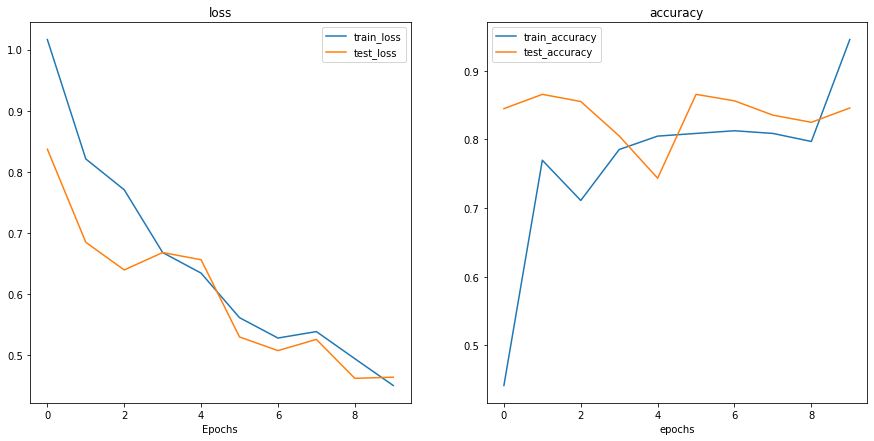

In [37]:
#Plotting curves to see how our model is performed
plot_loss_curves(results)